In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]

In [6]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [7]:
df_encoded=df_encoded.dropna()

In [8]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [9]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [10]:
scaler = PowerTransformer()
X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

In [11]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

# Auto-generate names: PC1, PC2, ..., PCn
pc_names = [f"PC{i+1}" for i in range(n_components)]

X_pca_df = pd.DataFrame(X_pca, columns=pc_names, index=X.index)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Shape after PCA:", X_pca_df.shape)
print(X_pca_df.head())


Explained variance ratio: [0.06878182 0.05522633 0.05207045 0.04020467 0.03270597 0.03123673
 0.02935527 0.02911874 0.02808513 0.02770787]
Shape after PCA: (856, 10)
         PC1        PC2        PC3       PC4       PC5       PC6       PC7  \
0 -13.286255  12.381636  -2.358979 -1.863974  6.214464  2.333033 -1.595674   
1  -8.755129  17.074635  -1.232722 -2.559045  9.528909  3.828398 -0.712112   
2  -6.118795 -14.033110   2.936905  1.606994  3.974660  1.453049 -1.010408   
3   4.888446 -13.401345 -11.516552  5.118760  0.632458 -2.973345  9.583541   
4  -7.846642  -9.349046  -0.867366  0.847673  7.082178  3.551114 -0.487902   

        PC8       PC9      PC10  
0  0.196443  1.531364 -1.621845  
1 -0.670457  1.880885 -4.645624  
2 -1.660768 -1.140706 -0.255090  
3 -4.909327 -0.858769 -4.473177  
4 -2.009106  1.230285 -3.301044  


In [12]:
X=X_pca_df

In [13]:
X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-13.286255,12.381636,-2.358979,-1.863974,6.214464,2.333033,-1.595674,0.196443,1.531364,-1.621845
1,-8.755129,17.074635,-1.232722,-2.559045,9.528909,3.828398,-0.712112,-0.670457,1.880885,-4.645624
2,-6.118795,-14.033110,2.936905,1.606994,3.974660,1.453049,-1.010408,-1.660768,-1.140706,-0.255090
3,4.888446,-13.401345,-11.516552,5.118760,0.632458,-2.973345,9.583541,-4.909327,-0.858769,-4.473177
4,-7.846642,-9.349046,-0.867366,0.847673,7.082178,3.551114,-0.487902,-2.009106,1.230285,-3.301044
...,...,...,...,...,...,...,...,...,...,...
851,-12.275088,18.902408,-1.180275,-2.328225,7.949455,3.689748,-0.845471,-1.058882,0.889592,-1.938580
852,0.184976,-2.069586,28.015689,4.403404,-13.510053,-5.202885,3.035892,-2.891495,-20.735099,-1.247505
853,12.976574,3.670930,-2.700456,-19.939472,11.517105,1.160724,0.023575,6.310212,-1.566510,3.363692
854,32.401617,9.386854,-9.215144,7.159040,-10.273070,-4.825307,-28.736060,16.217580,-9.376882,-8.439010


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import PredefinedSplit

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
     'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'sampling_strategy': uniform(0.1, 0.6)
    #'max_leaf_nodes': randint(10, 100)
}

model = BalancedRandomForestClassifier(random_state=42, n_jobs=1, replacement=True, bootstrap=True)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=100,                  # number of random combinations to try
    #cv=ps,
    cv=4,
    scoring="average_precision",
    n_jobs=1,
    verbose=1,
    random_state=42
)

#random_search.fit(X_combined, y_combined)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters: {'max_depth': 44, 'min_samples_split': 2, 'n_estimators': 366, 'sampling_strategy': 0.3046398106301551}
Best score: 0.11631902474670631


In [16]:
y_pred=random_search.predict(X_test)
y_proba=random_search.predict_proba(X_test)[:,1]

In [17]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9794    0.9482    0.9636       251
           1     0.0714    0.1667    0.1000         6

    accuracy                         0.9300       257
   macro avg     0.5254    0.5574    0.5318       257
weighted avg     0.9582    0.9300    0.9434       257



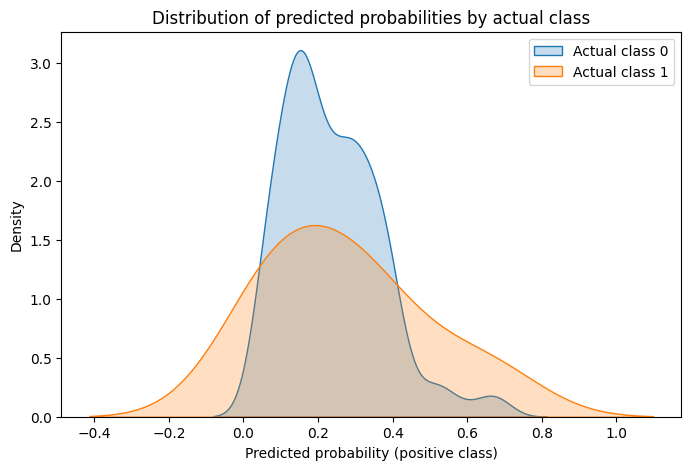

In [18]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [19]:
X_test.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], dtype='object')